# Dimensionality reduction

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Tutorial 6

Setting up the environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import pickle

%matplotlib inline

## Toy dataset for debugging

Write a function that generates data from two Gaussians with unit variance, centered at $\mathbf{1}$ and $-\mathbf{1}$ respectively. $\mathbf{1}$ is the vector of all ones.

Use the function to generate 100 samples from each Gaussian, with a 5 dimensional feature space.

In [2]:
# Solution
def gen_data(n_samples=100, n_feat=5):
    """Generate data from two Gaussians
    n_samples = number of samples from each Gaussian
    n_feat = dimension of the features
    """
    X1 = np.ones((n_feat, n_samples)) + np.random.randn(n_feat, n_samples)
    X2 = -np.ones((n_feat, n_samples)) + np.random.randn(n_feat, n_samples)
    X = np.hstack([X1,X2])
    return X

toy_data = gen_data()


## Principal component analysis (PCA)

The **Singular Values** of a square matrix $A$ is defined as the square root of the eigenvalues of $A^T A$. Given a matrix $X$, the singular value decomposition (SVD) is given by
$$
X = U S V^T
$$
where $U$ and $V$ are orthogonal matrices containing the left and right singular vectors respectively. And $S$ is a matrix with the singular values along the diagonal.

Recall that PCA considers the covariance matrix of a data matrix $X$. Using the definition of SVD above, derive expressions for:
1. the eigenvectors
2. the projection of $X$ onto the $k$ largest eigenvalues


### Solution

The covariance $C$ is given by
$$
C = \frac{1}{n} XX^T.
$$
By substituting the definition of SVD,
$$
C = \frac{1}{n} USV^T VS^T U^T
$$
Since $V$ is an orthogonal matrix, $V^T V=\mathbf{I}$. Since $S$ is diagonal, $S^T=S$, and $S*S=S^2$, where $S^2$ is a diagonal matrix with the squared singular values on the diagonal. Therefore
$$
C = \frac{1}{n} US^2 U^T
$$

By comparing the equation above with the eigenvalue decomposition of $C$, we observe that the left singular vectors are eigenvectors.

Let $U_k$ be the matrix containing the eigenvectors corresponding to the $k$ largest eigenvalues. The projection of the data matrix $X$ is given by
$$
Z = U_k^T X = U_k^T USV^T
$$
Note that the matrix $U_k^T U$ essentially selects the first $k$ columns of $SV^T$.

## Implement PCA

Implement the principal component analysis method, using ```numpy.linalg.svd```. Your function should take the data matrix and return two matrices:
1. The projection of the data onto the principal components
2. The actual components (eigenvectors) themselves.

*Hint: do not forget to center the data by removing the mean*

In [3]:
# Solution
def pca(X, n_pc=2):
    """Returns the projection onto the principal components (default=2)"""
    n_samples, n_features = X.shape
    M = np.mean(X, axis=0)
    X -= M
    U, S, V = np.linalg.svd(X)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components

Obtain the projection of the toy data above to its first two principal components. Plot the results. You should be able to see that the first principal component already gives you the axis of discrimination.

(5, 200)


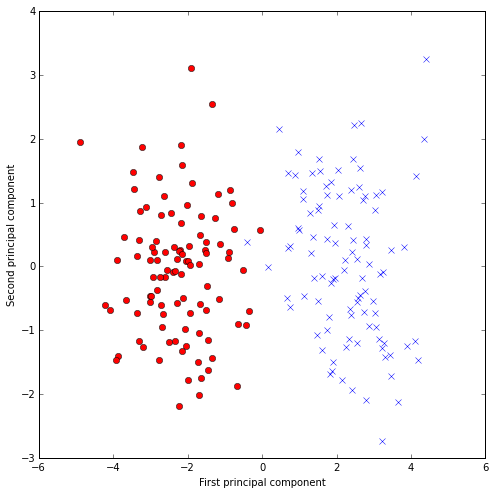

In [4]:
# Solution
print(toy_data.shape)
Z, P = pca(toy_data.T)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Z[:100,0], Z[:100,1], 'ro')
ax.plot(Z[100:,0], Z[100:,1], 'bx')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

## The classification data set

*You have seen this dataset in earlier tutorials*

We will predict the incidence of diabetes based on various measurements (see [description](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)). Instead of directly using the raw data, we use a normalised version, where the label to be predicted (the incidence of diabetes) is in the first column. Download the data from [mldata.org](http://mldata.org/repository/data/download/csv/diabetes_scale/).

Read in the data using pandas.

In [5]:
names = ['diabetes', 'num preg', 'plasma', 'bp', 'skin fold', 'insulin', 'bmi', 'pedigree', 'age']
data = pd.read_csv('diabetes_scale.csv', header=None, names=names)
data.diabetes.replace(-1, 0, inplace=True) # replace -1 with 0 because we need labels to be in {0, 1}
data.head()

,diabetes,num preg,plasma,bp,skin fold,insulin,bmi,pedigree,age
0,0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,0,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,0,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


Find the first two principal components of the features in the classification data set. Plot the scatter plot showing the examples projected onto the first two principal components. Use the labels to produce different symbols for each class. Discuss whether the first two principal components discriminate well.

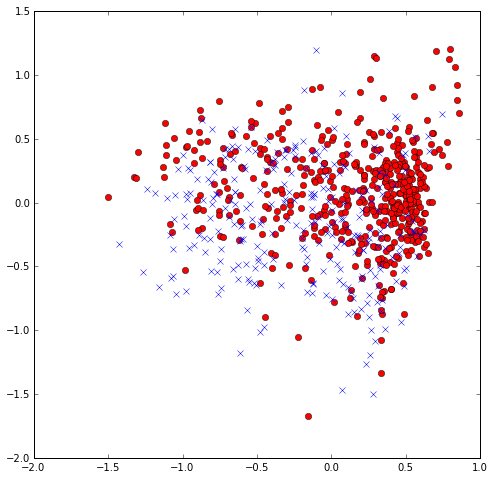

In [6]:
# Solution
features = ['num preg', 'plasma', 'bp', 'skin fold', 'insulin', 'bmi', 'pedigree', 'age']
X = data[features]
Y = data['diabetes']
pos_idx = np.where(Y==1)[0]
neg_idx = np.where(Y==0)[0]

Z, P = pca(X)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Z[pos_idx,0], Z[pos_idx,1], 'ro')
ax.plot(Z[neg_idx,0], Z[neg_idx,1], 'bx')

## (optional) Effect of normalisation on principal components

Plot the scatter plot of the first two principal components of the classification dataset respectively before and after the normalisations in Tutorial 2 and 5.

In [7]:
# Solution

## Using principal components as features for classification

Write a file containing the features projected onto the first 4 principal components, using the ```to_csv``` command of ```pandas```.

In [8]:
# Solution
Z, P = pca(X, n_pc=4)
col_names = ['diabetes', 'PC1', 'PC2', 'PC3', 'PC4', 'ones']
prin_data = pd.DataFrame(index=range(len(Y)), columns=col_names)
prin_data['diabetes'] = Y
prin_data.ix[:,1:-1] = Z
prin_data.ix[:,-1] = np.ones(len(Y))
prin_data.to_csv('prin_feat4.csv', index=False)

In [9]:
# Data should look something like the below
data = pd.read_csv('prin_feat4.csv')
data.head()

,diabetes,PC1,PC2,PC3,PC4,ones
0,0,-0.609911,-0.180765,0.040223,-0.035546,1
1,1,0.386596,0.145904,-0.255327,0.063593,1
2,0,-0.436217,0.255150,0.534630,-0.071021,1
3,1,0.597652,0.114307,-0.212423,0.040600,1
4,0,0.338991,-0.765498,0.627272,-0.572329,1


Use the first four principal components with your logistic regression code from Tutorial 3, and compare the results. For simplicity, compare the training error.

In [10]:
# Solution

# From Tutorial 3
def sigmoid(X):
    """S shaped function, known as the sigmoid"""
    return 1 / (1 + np.exp(- X))

def cost(theta, X, y):
    """The cost function for logistic regression"""
    p_1 = sigmoid(np.dot(X, theta)) # predicted probability of label 1
    log_l = (-y)*np.log(p_1) - (1-y)*np.log(1-p_1) # log-likelihood vector

    return log_l.mean()

def grad(theta, X, y):
    """The gradient of the cost function for logistic regresssion"""
    p_1 = sigmoid(np.dot(X, theta))
    error = p_1 - y # difference between label and prediction
    grad = np.dot(error, X) / y.size # gradient vector

    return grad

def train(X, y):
    """Train a logistic regression model for data X and labels y.
    returns the learned parameter.
    """
    n_feat = X.shape[1]
    theta = 0.1*np.random.randn(n_feat)
    theta_best = opt.fmin_bfgs(cost, theta, fprime=grad, args=(X, y))
    return theta_best

def predict(theta_best, Xtest):
    """Using the learned parameter theta_best, predict on data Xtest"""
    p = sigmoid(theta_best.dot(Xtest.T))
    for i in range(len(p)):
        if p[i] > 0.5:
            p[i] = 1
        else:
            p[i] = 0
    return p


def confusion_matrix(prediction, labels):
    """Returns the confusion matrix for a list of predictions and (correct) labels"""
    assert len(prediction) == len(labels)
    f = lambda p, l: len(list(filter(lambda x: x == (p, l), zip(prediction, labels))))
    return np.matrix([[f(1, 1), f(1, 0)], [f(0, 1), f(0, 0)]])

def accuracy(cmatrix):
    """Returns the accuracy of a confusion matrix"""
    tp, fp, fn, tn = cmatrix.flatten().tolist()[0]
    return (tp + tn) / (tp + fp + fn + tn)

In [11]:
# Solution

y = data['diabetes']
X = data[['PC1', 'PC2', 'PC3', 'PC4', 'ones']]
theta_best = train(X, y)
pred = predict(theta_best, X)
cmatrix = confusion_matrix(pred, y)
accuracy(cmatrix)

Optimization terminated successfully.
         Current function value: 0.515661
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31


0.73828125

## (optional) Explore noisy features

Use ```numpy.random.randn``` to generate 20 random features and add them to the diabetes dataset. How does logistic regression perform on all features? Can PCA be used to identify the signal?

In [12]:
# Solution

## Eigenfaces

The aim of this section of the tutorial is to see that in some cases, the principal components can be human interpretable.

The images below are of Colin Powell, resized to a smaller image, from [LFW](http://vis-www.cs.umass.edu/lfw/). Download the images from [the course website](https://sml.forge.nicta.com.au/isml16/tutorial/lfw_colin.pkl).

In [13]:
# Visualising images
def plot_gallery(images, titles, h, w, n_row=2, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())



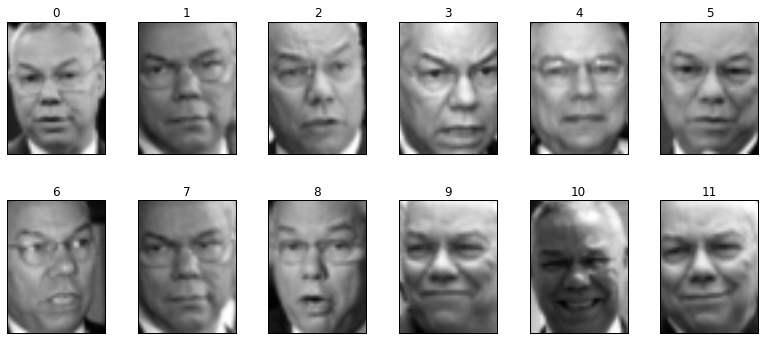

In [14]:
lfw_colin = pickle.load(open('lfw_colin.pkl', 'rb'))

# introspect the images array to find the shapes (for plotting)
n_samples, h, w = lfw_colin['images'].shape
plot_gallery(lfw_colin['images'], range(n_samples), h, w)


Use the ```pca``` function you wrote above to find the first 15 principal components. Visualise them. Discuss what the components potentially capture, for example lighting from the right.

*Hint: Images need to be converted into a vector for PCA, and the results need to be converted back*

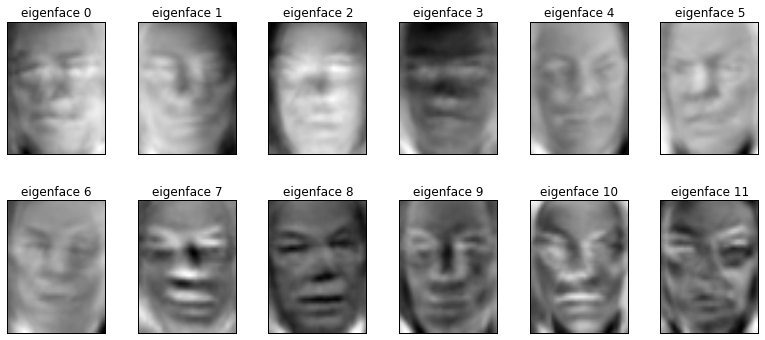

In [15]:
# Solution
n_components = 15
X = lfw_colin['images'].reshape(n_samples, h*w)
Z, P = pca(X, n_pc=n_components)
eigenfaces = P.reshape((n_components, h, w))
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)